In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import os

In [2]:
path = 'E:\\Data_Science\\OpenClassRoom\\Projet 5\\archive\\'
cust_df=pd.read_csv(path + 'olist_customers_dataset.csv')
geo_df=pd.read_csv(path +'olist_geolocation_dataset.csv')
ord_it_df=pd.read_csv(path + 'olist_order_items_dataset.csv')
ord_pay_df=pd.read_csv(path + 'olist_order_payments_dataset.csv')
ord_rev_df=pd.read_csv(path + 'olist_order_reviews_dataset.csv')
ord_df=pd.read_csv(path + 'olist_orders_dataset.csv')
prod_df=pd.read_csv(path + 'olist_products_dataset.csv')
sell_df=pd.read_csv(path + 'olist_sellers_dataset.csv')

In [3]:
dfs = {0:cust_df,1:geo_df,2:ord_it_df,3:ord_pay_df,4:ord_rev_df,5:ord_df,6:prod_df,7:sell_df}

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-n

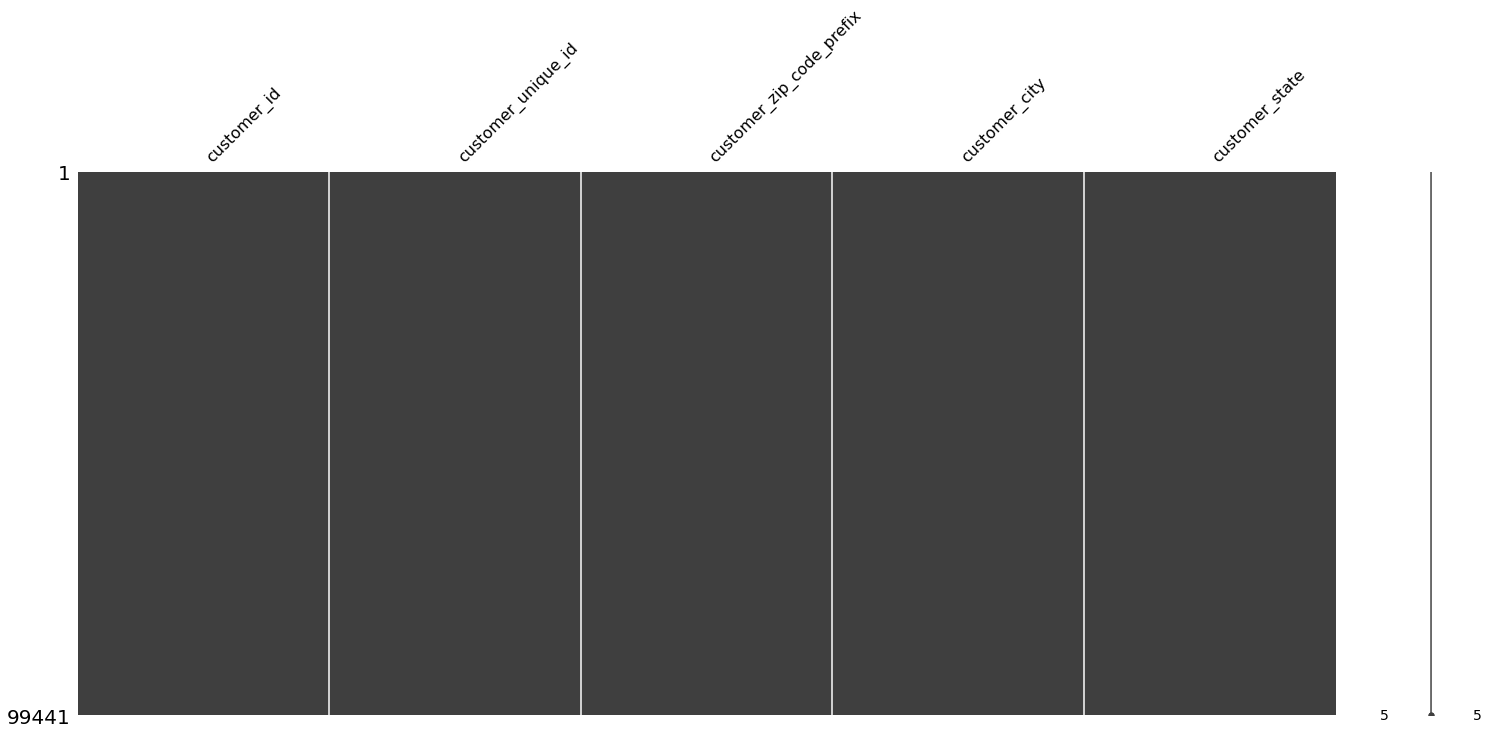

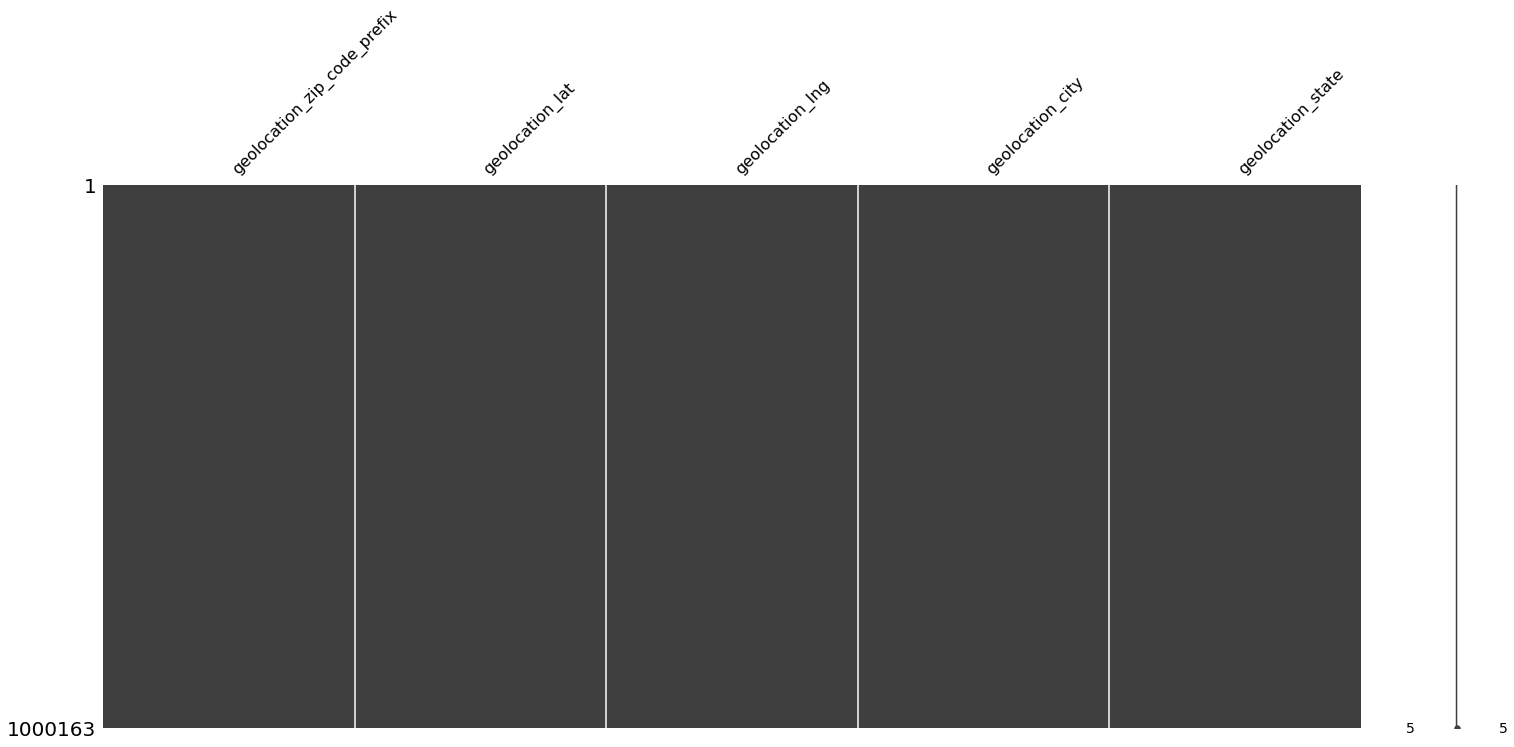

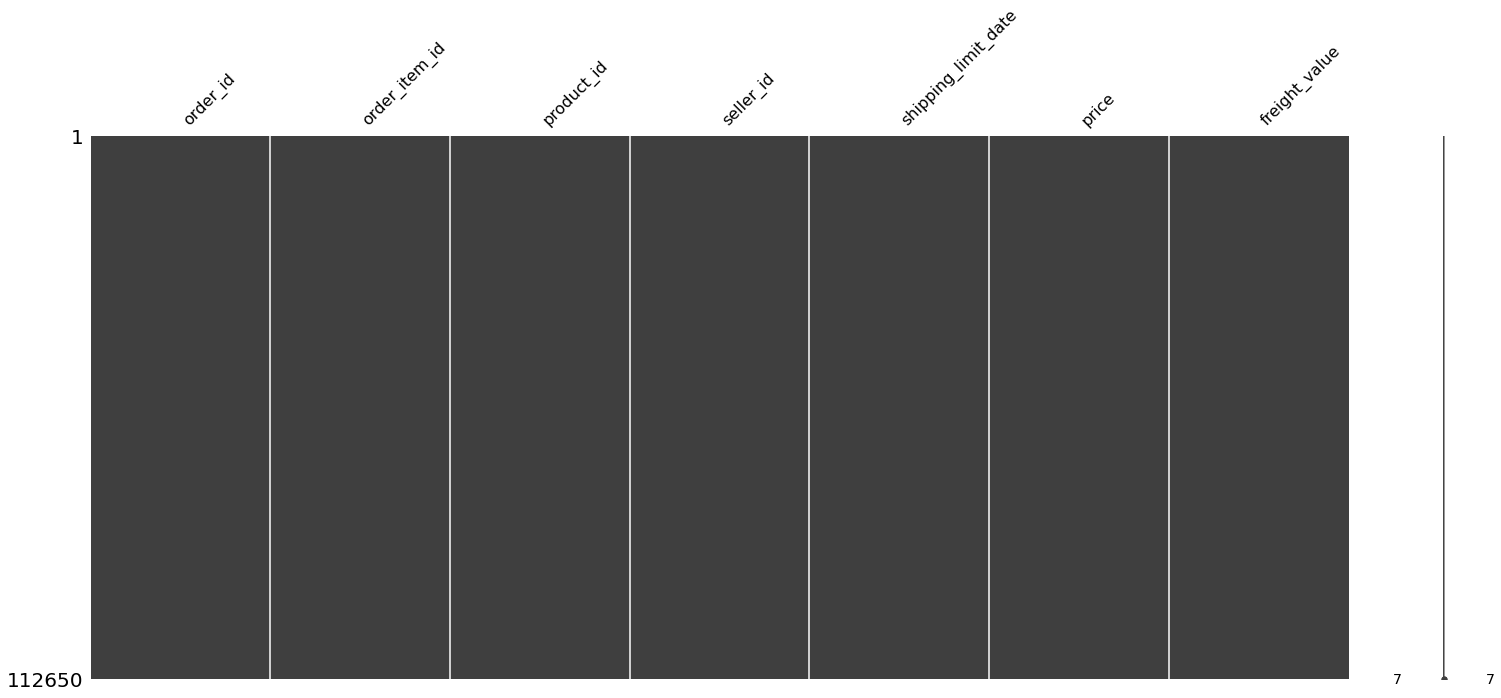

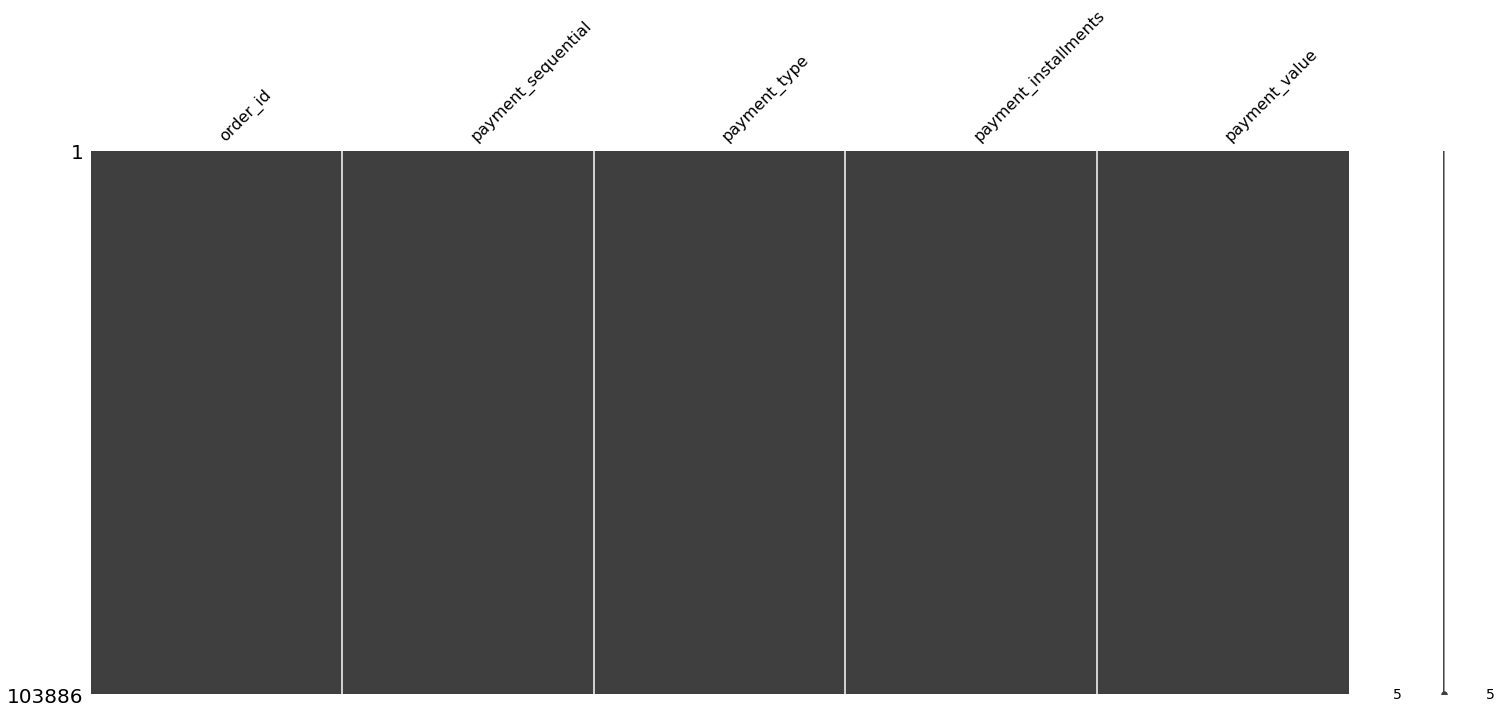

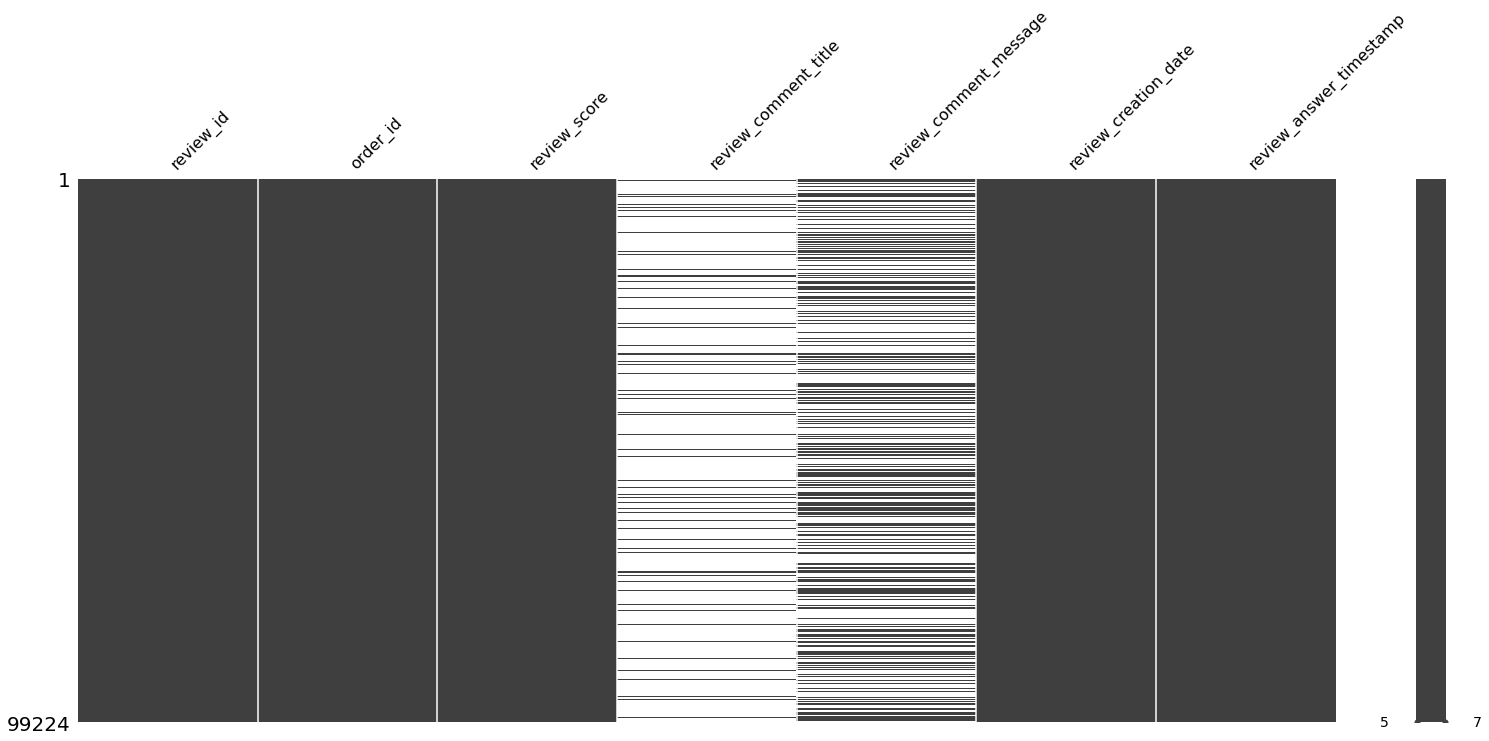

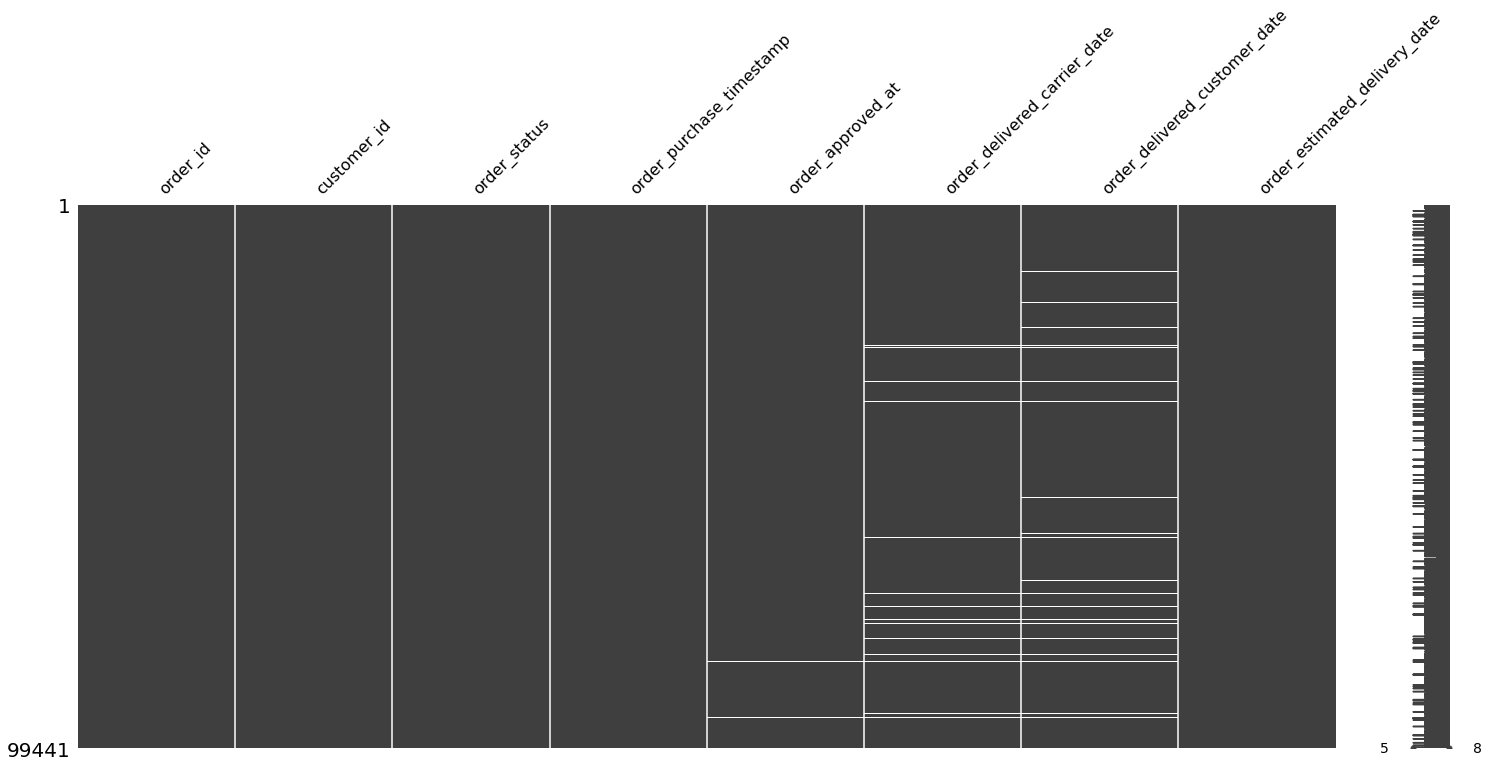

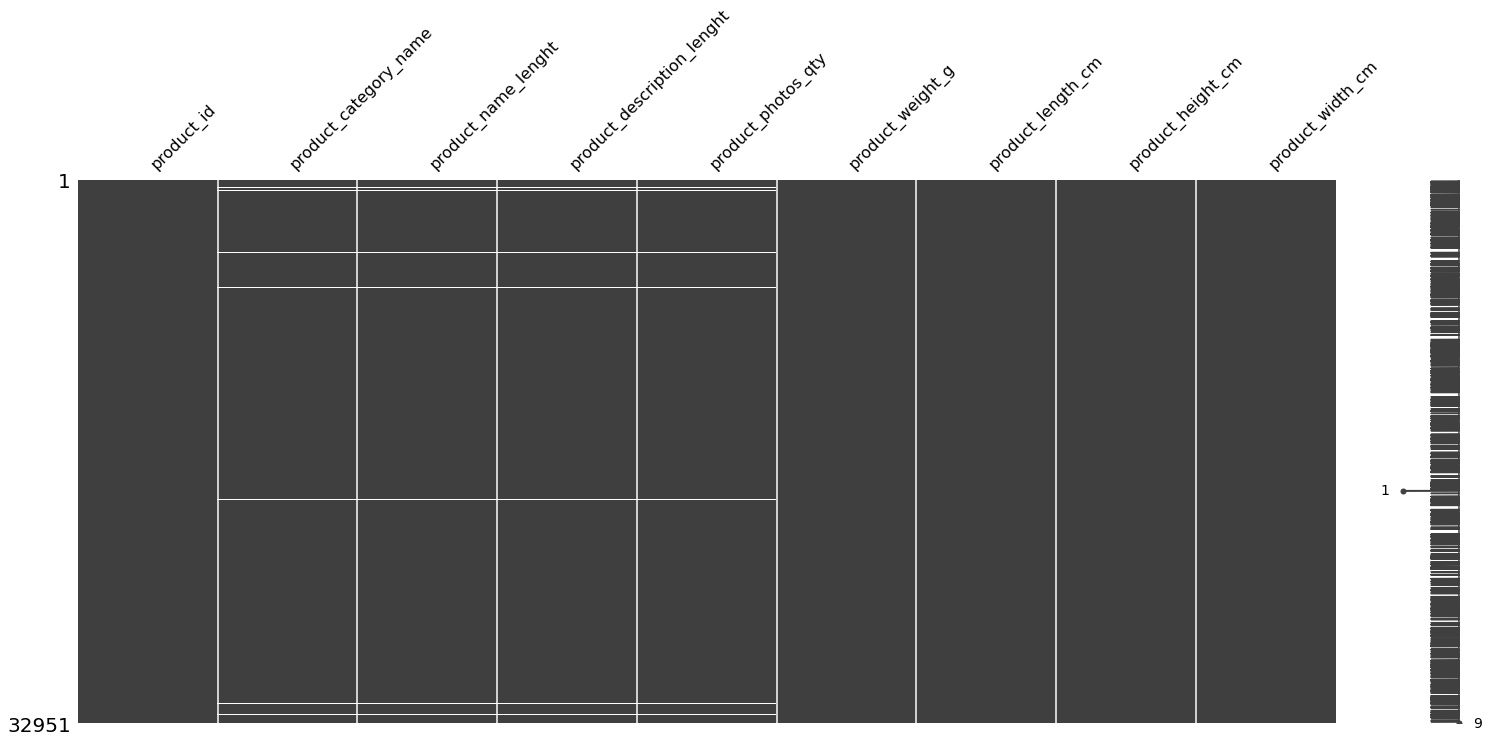

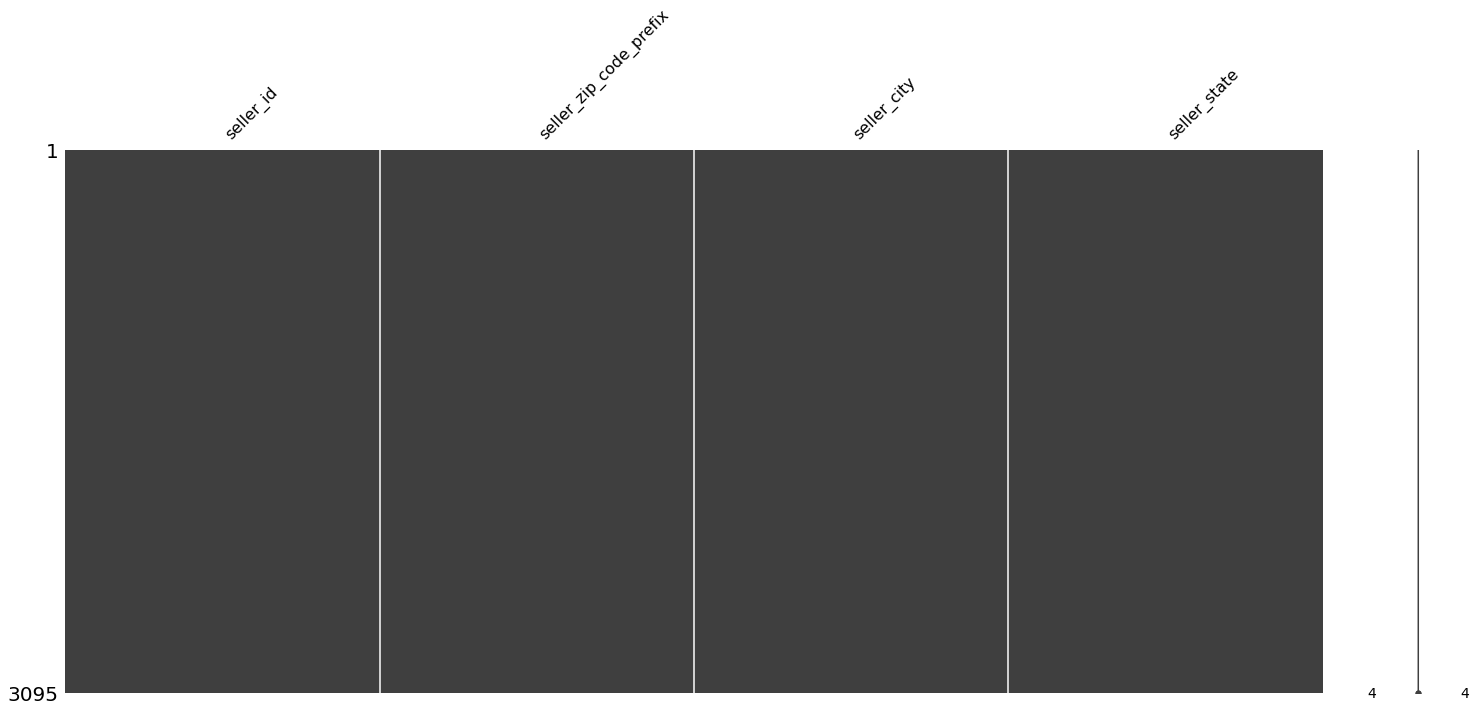

In [4]:
for i in dfs:
    print(dfs[i].info())
    msno.matrix(dfs[i])

In [265]:
#get the customers that ordered more than once
multi_cust_df = dfs[0][dfs[0].groupby('customer_unique_id').customer_unique_id.transform('count') > 1]

#get their customer_id
multi_custom = multi_cust_df[['customer_id','customer_unique_id']]
multi_id = multi_custom['customer_id']
multi_uni_id = multi_custom['customer_unique_id']
#get their order_id
multi_order_df = dfs[5][dfs[5]['customer_id'].isin(multi_id)]
multi_order_id = multi_order_df['order_id']

multi_pay_df = dfs[3][dfs[3]['order_id'].isin(multi_order_id)]
#get their review score
multi_rev_df = dfs[4][dfs[4]['order_id'].isin(multi_order_id)]



In [271]:
multi_order_id.shape

(6342,)

In [276]:
x = dfs[0]['customer_id'].unique().shape[0]
y = dfs[0]['customer_unique_id'].unique().shape[0]
print(x,y, 1-(y/x))

99441 96096 0.033638036624732304


In [267]:
import time
import datetime

def days(x):
    td = time.time()
    t = time.mktime(datetime.datetime.strptime(str(x),"%Y-%m-%d %H:%M:%S").timetuple())
    d = int((td - t)/86400)
    return d

In [279]:
##build the working df of each order
#take the customer id
df = pd.DataFrame(multi_custom)
df = df.set_index('customer_id')
df = df.join(multi_order_df[['customer_id','order_id', 'order_purchase_timestamp']].set_index('customer_id'))
#take the value of each order
temp = pd.DataFrame()
temp['order_total'] = multi_pay_df.groupby('order_id').payment_value.sum() #some order have voucher
df = df.join(temp, on = 'order_id')
#calculate the days since order of each order
df['days_since_order'] = df['order_purchase_timestamp'].apply(days)
#take the review score for each order
temp = pd.DataFrame(index = multi_rev_df.index)
temp['review_days'] = multi_rev_df['review_creation_date'].apply(days)
temp = temp.join(multi_rev_df[['order_id', 'review_score']])
agg_fun = {'review_days' : ['min'], 'review_score' : ['mean']}
temp = temp.groupby('order_id').agg(agg_fun)
df = df.join(temp, on = 'order_id', how='right')
df = df.drop(df.columns[5], axis=1 ) 
df = df.rename(columns = {df.columns[5] : 'review_score'})

df = df[df.groupby('customer_unique_id').customer_unique_id.transform('count') > 1] #some customer didn't review all their orders
print(df.info(),df.head())

<class 'pandas.core.frame.DataFrame'>
Index: 6244 entries, f6dd3ec061db4e3987629fe6b26e5cce to c5d108ecadaedf367e995520d36c9b1d
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_unique_id        6244 non-null   object 
 1   order_id                  6244 non-null   object 
 2   order_purchase_timestamp  6244 non-null   object 
 3   order_total               6244 non-null   float64
 4   days_since_order          6244 non-null   int64  
 5   review_score              6244 non-null   float64
dtypes: float64(2), int64(1), object(3)
memory usage: 341.5+ KB
None                                                 customer_unique_id  \
customer_id                                                          
f6dd3ec061db4e3987629fe6b26e5cce  eb28e67c4c0b83846050ddfb8a35d051   
8085a9af46f619bc25966f151a362b0d  98758d88bf4b8eef1372ddee45d63178   
0c45155afd8ff99622c40824057f9b34  87ae4c644c15d9c6b

E:\temp\ipykernel_34956\1820562360.py:18: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  df = df.join(temp, on = 'order_id', how='right')


In [278]:
#build the model df
md_df = pd.DataFrame(index = df['customer_unique_id'].unique())
#feature  = number of order
md_df['n_order'] = df.groupby('customer_unique_id').order_id.count()
#feature  = total value of orders
md_df['payment_total'] = df.groupby('customer_unique_id').order_total.agg('sum')
#feature  = mean and std of orders
md_df['payment_mean'] = df.groupby('customer_unique_id').order_total.agg('mean')
md_df['payment_std'] = df.groupby('customer_unique_id').order_total.agg('std')
#feature number of order on the distrib
df['order_dis'] = pd.cut(df['order_total'],10, duplicates = 'drop')
md_df = md_df.join(pd.crosstab(df['customer_unique_id'], df['order_dis'], values = df['order_dis'], aggfunc='count'))
#feature review score mean and std
md_df['rev_mean'] = df.groupby('customer_unique_id').review_score.agg('mean')
md_df['rev_std'] = df.groupby('customer_unique_id').review_score.agg('std')
#feature  = days since last order
md_df['days_since_last_order'] = df.groupby('customer_unique_id').days_since_order.agg('min')


print(md_df.info(),md_df.head(),md_df.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 2951 entries, eb28e67c4c0b83846050ddfb8a35d051 to acc4424c209233de519e034152f30304
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   n_order                2951 non-null   int64  
 1   payment_total          2951 non-null   float64
 2   payment_mean           2951 non-null   float64
 3   payment_std            2951 non-null   float64
 4   (-4.95, 495.034]       2951 non-null   int64  
 5   (495.034, 990.068]     2951 non-null   int64  
 6   (990.068, 1485.102]    2951 non-null   int64  
 7   (1485.102, 1980.136]   2951 non-null   int64  
 8   (1980.136, 2475.17]    2951 non-null   int64  
 9   (2475.17, 2970.204]    2951 non-null   int64  
 10  (2970.204, 3465.238]   2951 non-null   int64  
 11  (3465.238, 3960.272]   2951 non-null   int64  
 12  (3960.272, 4455.306]   2951 non-null   int64  
 13  (4455.306, 4950.34]    2951 non-null   int64  
 14  re

<AxesSubplot:>

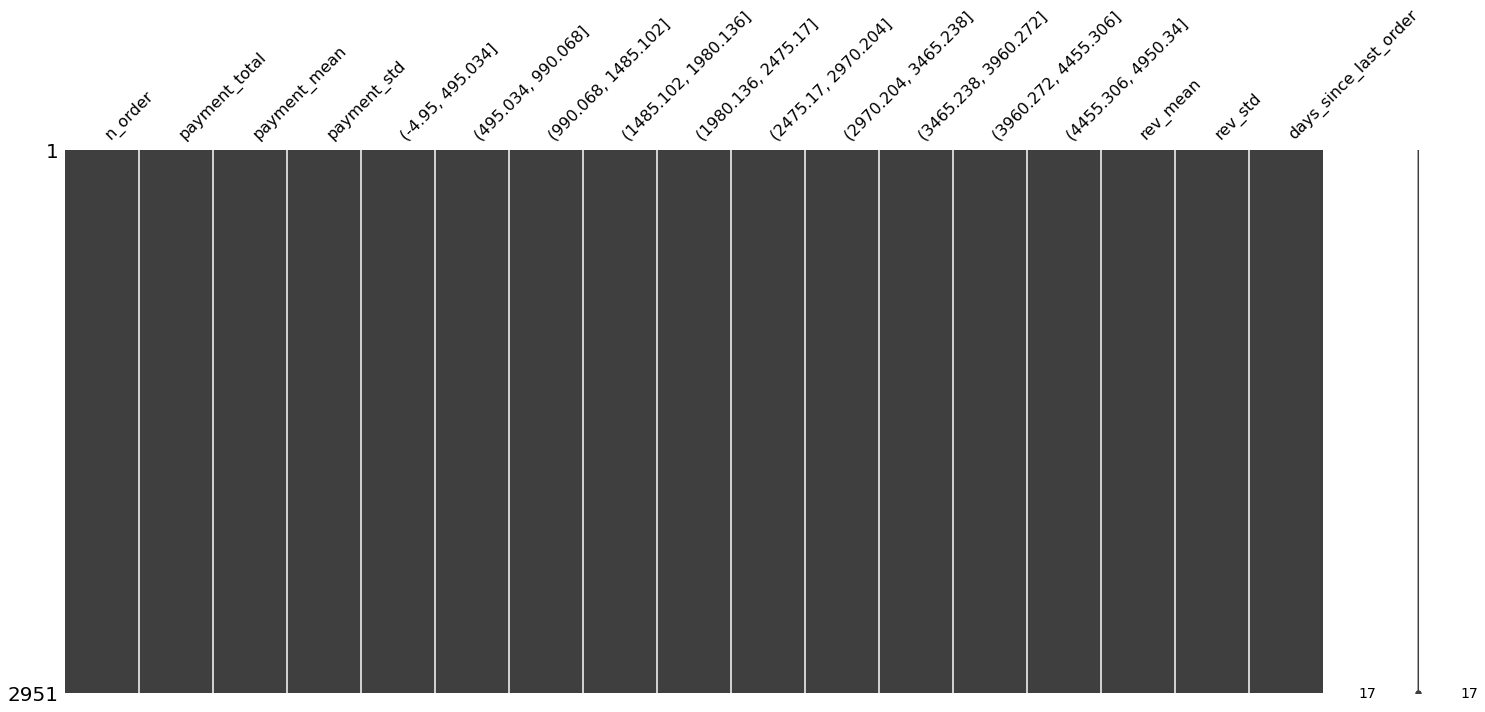

In [280]:
msno.matrix(md_df)

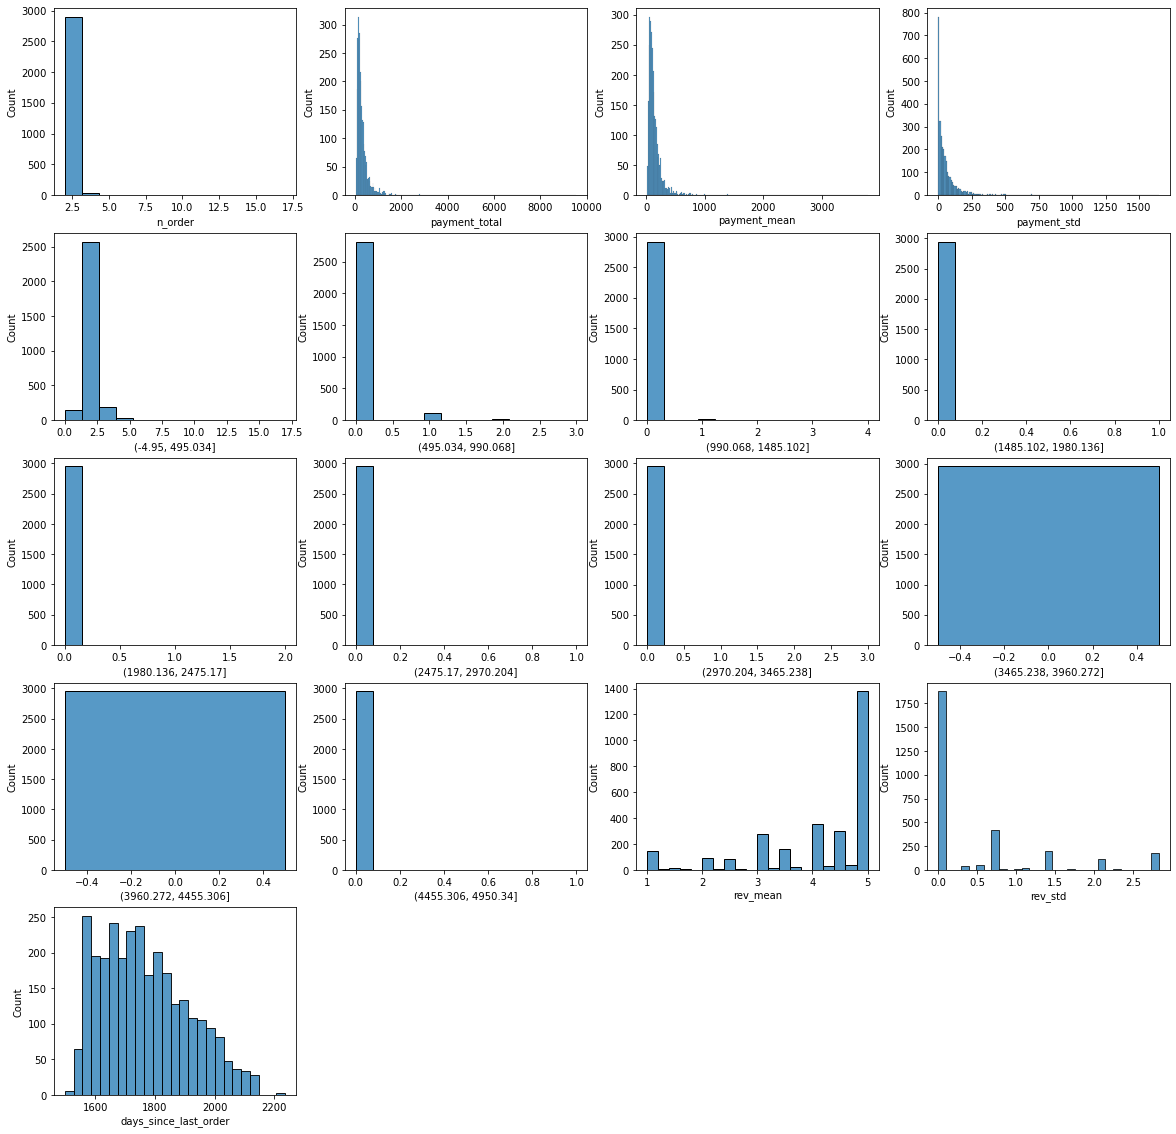

In [281]:

fig = plt.figure(figsize=(20,20))
for i in range(md_df.shape[1]):
    ax = fig.add_subplot(int((md_df.shape[1]/4)+1), 4, i+1)
    sns.histplot(md_df.iloc[:,i], ax = ax)

plt.show()

In [282]:
md_df.to_csv('md_df.csv', index = False)

## Dimention reduction

In [283]:
dim_df = pd.read_csv('md_df.csv')
x = dim_df.values
features = dim_df.columns

In [284]:
dim_df.isna().sum()

n_order                  0
payment_total            0
payment_mean             0
payment_std              0
(-4.95, 495.034]         0
(495.034, 990.068]       0
(990.068, 1485.102]      0
(1485.102, 1980.136]     0
(1980.136, 2475.17]      0
(2475.17, 2970.204]      0
(2970.204, 3465.238]     0
(3465.238, 3960.272]     0
(3960.272, 4455.306]     0
(4455.306, 4950.34]      0
rev_mean                 0
rev_std                  0
days_since_last_order    0
dtype: int64

In [292]:
from sklearn import decomposition
from sklearn import preprocessing

pca = decomposition.PCA(n_components = 2)
scaler = preprocessing.StandardScaler()
x_scale = preprocessing.scale(x)

pca.fit(x_scale)

PCA(n_components=2)

In [293]:
scree = (pca.explained_variance_ratio_*100).round(2).cumsum()
print(scree)

[24.37 36.82]


In [294]:
pd.DataFrame(pca.components_, columns = features, index = ['F1', 'F2'])



,n_order,payment_total,payment_mean,payment_std,"(-4.95, 495.034]","(495.034, 990.068]","(990.068, 1485.102]","(1485.102, 1980.136]","(1980.136, 2475.17]","(2475.17, 2970.204]","(2970.204, 3465.238]","(3465.238, 3960.272]","(3960.272, 4455.306]","(4455.306, 4950.34]",rev_mean,rev_std,days_since_last_order
F1,-0.034576,0.478851,0.501855,0.381355,-0.245282,0.260315,0.217299,0.141104,0.105335,0.272117,0.151557,-0.0,-0.0,0.257533,-0.044383,0.025361,-0.010534
F2,0.662502,0.160445,0.048299,0.030680,0.633315,-0.164337,-0.010188,-0.006550,-0.021751,0.195241,0.077954,-0.0,-0.0,0.209023,0.102516,-0.043987,-0.055038


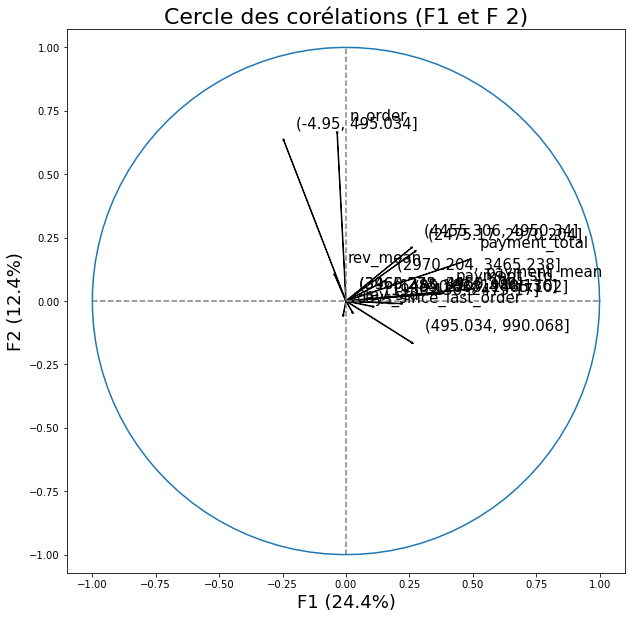

<Figure size 432x288 with 0 Axes>

In [295]:
x, y = 0,1 #define factorial space, (0,1) define the first factorial plane (F1, F2), (2,3) define the second (F3,F4) and so on(tuple)

fig, ax = plt.subplots(figsize = (10,10))
for i in range(0, pca.components_.shape[1]):
    ax.arrow(0,0, #start the arrow at the origin
                    pca.components_[0,i], #coordinate for PC1
                    pca.components_[1,i], #coordinate for PC2
                    head_width = 0.007,
                    head_length = 0.007,
                    width=0.002,) #graphical aspect of the arrow
    plt.text(pca.components_[0,i] + 0.05,
                        pca.components_[1,i] + 0.05,
                        features[i], fontsize = 15) # plot the text near each arrow head
plt.plot([-1,1], [0,0], color = 'grey', ls='--')
plt.plot([0,0], [-1,1], color='grey', ls='--') #plot the lines (abscissa and ordonate)

plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)), fontsize = 18) #label the axis with the percentage of explained variance
plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)),fontsize = 18)

plt.title('Cercle des corélations (F{} et F {})'.format(x+1, y+1), fontsize = 22)

an = np.linspace(0, 2 * np.pi, 100) #return an np.array of the coordinates (100) of a circle of circonference 1 (2*pi)
plt.plot(np.cos(an), np.sin(an)) #plot the circle
plt.axis('equal') #set equal scaling
plt.show()
plt.clf()

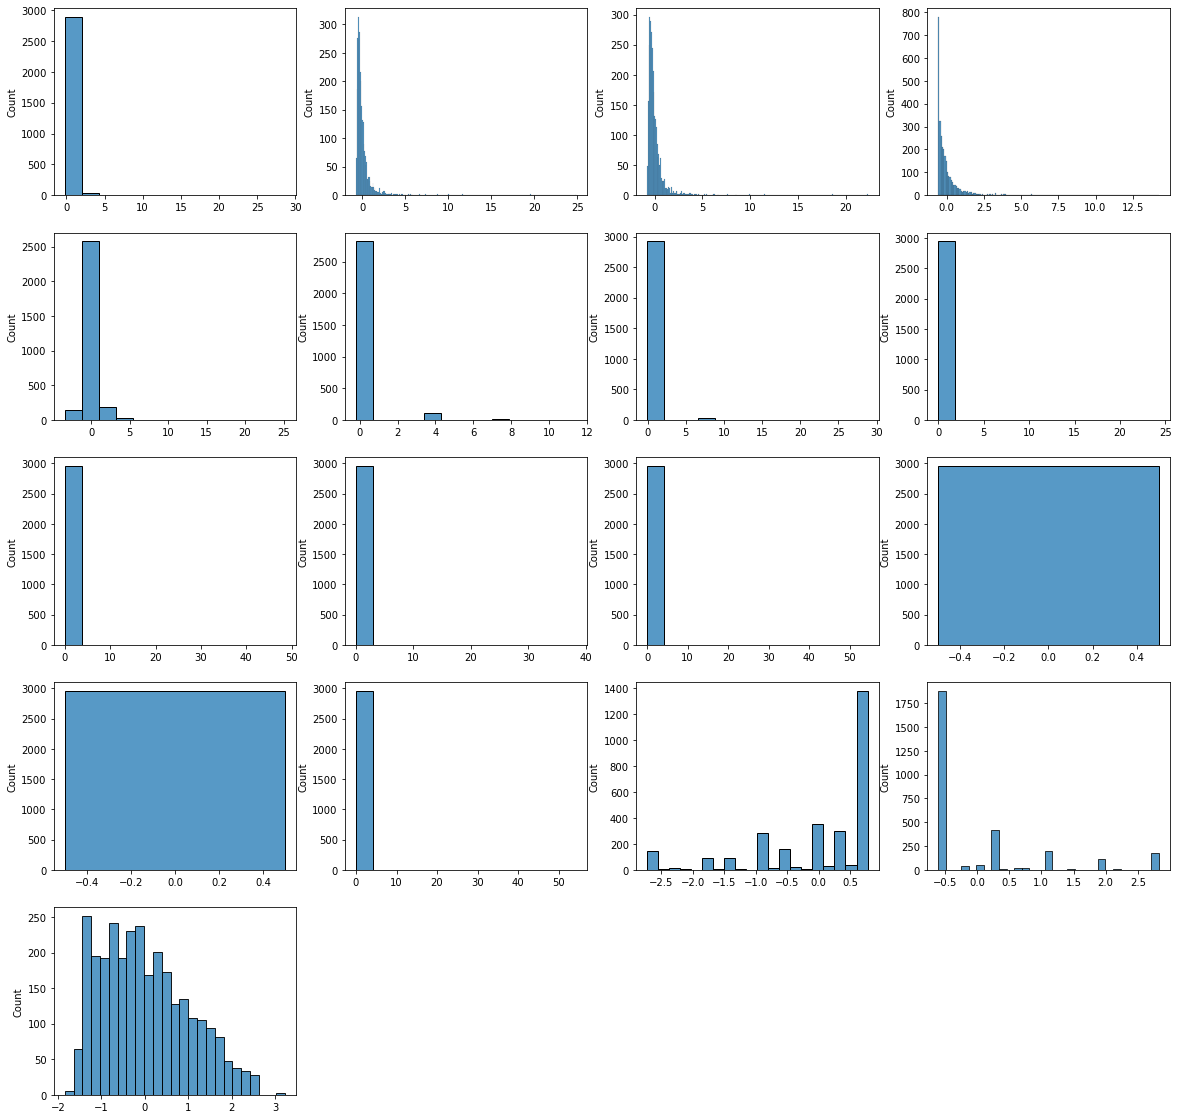

In [296]:
fig = plt.figure(figsize=(20,20))
for i in range(x_scale.shape[1]):
    ax = fig.add_subplot(int((x_scale.shape[1]/4)+1), 4, i+1)
    sns.histplot(x_scale[:,i], ax = ax)

plt.show()

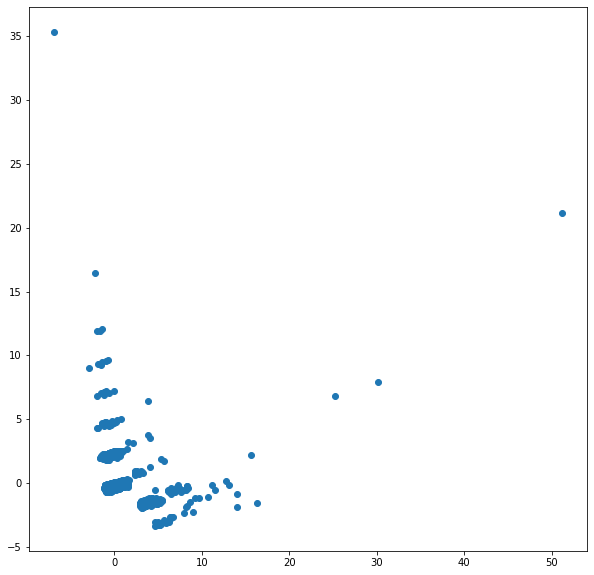

In [297]:
x_proj = pca.transform(x_scale)
fig, ax = plt.subplots(figsize = (10,10))
ax.scatter(x_proj[:,0],x_proj[:,1])
plt.show()

In [298]:
from sklearn import cluster, metrics

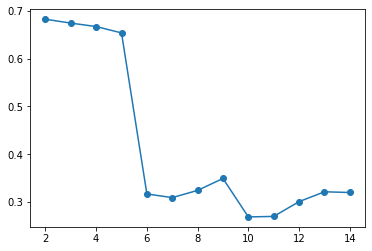

In [299]:
silhouette = []
for i in range(2,15):
    clus = cluster.KMeans(n_clusters = i)
    clus.fit(x_scale)
    sil  = metrics.silhouette_score(x_scale, clus.labels_)
    silhouette.append(sil)
    
plt.plot(range(2,15), silhouette, marker ='o')


In [300]:
from sklearn.manifold import Isomap
iso = Isomap()
from sklearn.manifold import MDS
mds = MDS()
from sklearn.manifold import TSNE
tsne = TSNE()

x_proj2 = mds.fit_transform(x_scale)
x_proj3 = tsne.fit_transform(x_scale)
x_proj4 = iso.fit_transform(x_scale)

E:\Data_Science\Anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
E:\Data_Science\Anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
E:\Data_Science\Anaconda\lib\site-packages\sklearn\manifold\_isomap.py:324: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
E:\Data_Science\Anaconda\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


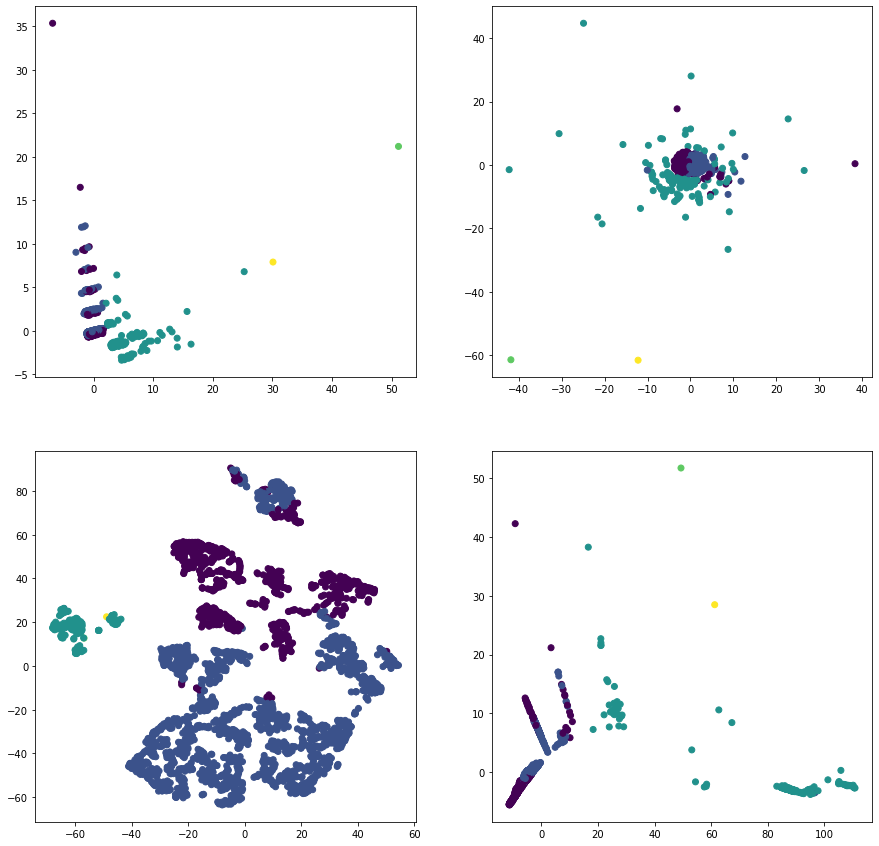

In [301]:
clus = cluster.KMeans(n_clusters = 5)
clus.fit(x_scale)

fig,ax =plt.subplots(2,2,figsize = (15,15))
ax[0,0].scatter(x_proj[:,0], x_proj[:,1], c=clus.labels_)
ax[0,1].scatter(x_proj2[:,0], x_proj2[:,1], c=clus.labels_)
ax[1,0].scatter(x_proj3[:,0], x_proj3[:,1], c=clus.labels_)
ax[1,1].scatter(x_proj4[:,0], x_proj4[:,1], c=clus.labels_)
plt.show()

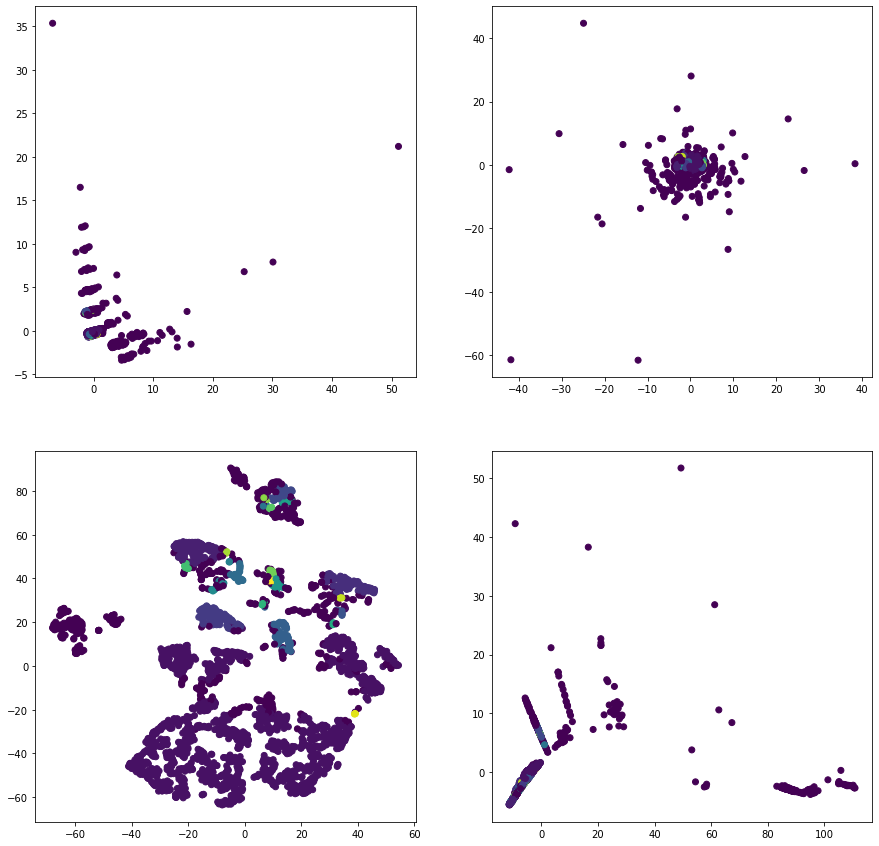

In [302]:
dbscan = cluster.DBSCAN()
dbscan.fit(x_scale)

fig,ax =plt.subplots(2,2,figsize = (15,15))
ax[0,0].scatter(x_proj[:,0], x_proj[:,1], c=dbscan.labels_)
ax[0,1].scatter(x_proj2[:,0], x_proj2[:,1], c=dbscan.labels_)
ax[1,0].scatter(x_proj3[:,0], x_proj3[:,1], c=dbscan.labels_)
ax[1,1].scatter(x_proj4[:,0], x_proj4[:,1], c=dbscan.labels_)
plt.show()

In [303]:
md_df['clus_label'] = clus.labels_
md_df['dbscan_label'] = dbscan.labels_

In [28]:
md_df.loc[md_df['clus_label'] == 0].describe()


,n_order,payment_total,payment_mean,payment_std,days_since_last_order,clus_label,dbscan_label
count,2843.000000,2843.000000,2843.000000,2843.000000,2843.000000,2843.0,2843.000000
mean,2.112557,260.118495,123.327553,48.178754,1765.815336,0.0,0.026381
std,0.517118,163.811038,73.634017,54.815709,146.070643,0.0,0.313333
min,2.000000,34.970000,15.620000,0.000000,1497.000000,0.0,-1.000000
25%,2.000000,142.725000,69.897500,7.781710,1649.000000,0.0,0.000000
50%,2.000000,216.570000,104.985000,30.023754,1745.000000,0.0,0.000000
75%,2.000000,334.775000,159.225000,66.468037,1865.500000,0.0,0.000000
max,17.000000,1172.660000,523.575000,318.148554,2237.000000,0.0,2.000000


In [29]:
md_df.loc[md_df['clus_label'] == 1].describe()

,n_order,payment_total,payment_mean,payment_std,days_since_last_order,clus_label,dbscan_label
count,154.000000,154.000000,154.000000,154.000000,154.000000,154.0,154.000000
mean,2.181818,1327.959935,613.220137,381.015851,1745.707792,1.0,-0.681818
std,0.504289,1042.885784,433.135801,289.998711,130.391162,0.0,1.124327
min,2.000000,585.910000,241.835000,0.000000,1554.000000,1.0,-1.000000
25%,2.000000,859.080000,400.983750,203.515938,1630.250000,1.0,-1.000000
50%,2.000000,1056.160000,502.245000,357.841993,1736.500000,1.0,-1.000000
75%,2.000000,1439.267500,651.318750,492.954189,1844.500000,1.0,-1.000000
max,5.000000,9553.020000,3785.815000,1646.887049,2060.000000,1.0,4.000000


In [304]:
temp = np.unique(dbscan.labels_)
fig = plt.figure(figsize = (20,20))
plt.subplots_adjust(top=0.35)
for e,i in enumerate(temp):
    temp_df = pd.DataFrame(md_df.loc[md_df['dbscan_label'] == i].describe())
    ax = fig.add_subplot(int(temp.shape[0]/3)+1, 2, e+1)
    ax.axis('off')
    table = ax.table(cellText = temp_df.values,
            colLabels = temp_df.columns,
            rowLabels = temp_df.index,
            )
    table.set_fontsize = 15
plt.show()

ValueError: num must be 1 <= num <= 18, not 19

Error in callback <function flush_figures at 0x000001BCE7198670> (for post_execute):



KeyboardInterrupt



In [306]:
for i in temp:
    print(i,md_df.loc[md_df['dbscan_label'] == i].describe())

-1           n_order  payment_total  payment_mean  payment_std  (-4.95, 495.034]  \
count  668.000000     668.000000    668.000000   668.000000        668.000000   
mean     2.404192     642.018578    286.048637   155.542750          2.094311   
std      0.989350     651.393836    286.003786   195.148914          1.202857   
min      2.000000      39.340000     15.620000     0.000000          0.000000   
25%      2.000000     324.967500    135.396250    29.511102          2.000000   
50%      2.000000     500.360000    224.005000    97.174149          2.000000   
75%      3.000000     770.012500    346.945000   211.028948          2.000000   
max     17.000000    9553.020000   3785.815000  1646.887049         17.000000   

       (495.034, 990.068]  (990.068, 1485.102]  (1485.102, 1980.136]  \
count          668.000000           668.000000            668.000000   
mean             0.233533             0.055389              0.007485   
std              0.501226             0.287027     